In [1]:
from datetime import datetime

import pickle
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from pandas_profiling import ProfileReport
# from google.colab import files

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#!pip install lightgbm
#!pip install --user mlxtend
#!pip install xgboost

## Data Extraction

In [3]:
# Extract data from Nat2021us_small_200000.txt and construct a dataframe

# it takes two minutes to load this 
def load_file_extract_data():
    col_mapping = []
    col_mapping.append([9,  12, 'birth_year']) # 2021
    col_mapping.append([13, 14, 'birth_month']) # 01=Jan, 12=Dec
    col_mapping.append([19, 20, 'time_of_birth']) # HH. 9999=Not Staetd
    col_mapping.append([23, 23, 'birth_day_of_week']) # 1=Sunday, 7=Saturday
    col_mapping.append([32, 32, 'birth_place']) # 1=hospital, 2=freestanding birth center, 3=home(intended), ... 9=Unknown
    col_mapping.append([75, 76, 'mother_age']) # 12=10-12years-old, 13=13, ... 50=50 and over
    col_mapping.append([84, 84, 'mother_nativity']) # 1=born in the US, 2=born outside the US, 3=Unknown
    col_mapping.append([104,104,'residence_status'])
    col_mapping.append([105,106,'mother_race1']) # detailed breakdown, 31 values
    col_mapping.append([107,107,'mother_race2']) # only 6 groups
    col_mapping.append([108,109,'mother_race3']) # 15 groups
    col_mapping.append([115,115,'mother_hispanic_origin']) # non-hispanic, mexican, puerto rican, etc
    col_mapping.append([117,117,'mother_hispanic_race']) # hispanic, non-hispanic-white, non-hispanic black, etc
    col_mapping.append([119,119,'paternity_acknowledged']) # Y/N, U=unknonw, X=N/A
    col_mapping.append([120,120,'marital_status']) # 1=Married, 2=Unmarried, 3=Unmarried not living together, 9=Unknown
    col_mapping.append([124,124,'mother_education']) # 1=8th grade or less, 2=9th-12th grade, ... 9=Unknown
    col_mapping.append([147,148,'father_age']) # 09-98, 99-unknown or not stated
    col_mapping.append([151,152,'father_race1']) # detailed breakdown, 31 values
    col_mapping.append([153,153,'father_race2']) # only 6 groups
    col_mapping.append([154,155,'father_race3']) # 15 groups
    col_mapping.append([159,159,'father_hispanic_origin']) # non-hispanic, mexican, puerto rican, etc
    col_mapping.append([162,162,'father_hispanic_race']) # hispanic, non-hispanic-white, non-hispanic black, etc
    col_mapping.append([163,163,'father_education']) # 1=8th grade or less, 2=9th-12th grade, ... 9=Unknown
    col_mapping.append([171,172,'prior_births_now_living']) # 0-30 number of children living from previous births, 99=Unknown
    col_mapping.append([173,174,'prior_births_now_dead']) # 0-30 number of children dead from previous births, 99=Unknown
    col_mapping.append([182,182,'total_birth_order']) # 1-7 total birth order, 8 or more total births, 9=Unknown
    col_mapping.append([201,202,'interval_since_last_live_birth']) # 00(zero-to-3months plural delivery), 01=04-11month, 02=12-17months
    col_mapping.append([227,227,'month_prenatal_care_began']) # 1=1st-3rd month, 2=4th-6th month, 3=7th-final, 4=no prenatal, 5=unknown
    col_mapping.append([242,243,'number_of_prenatal_visits']) # 00-98, 99=Unknown
    col_mapping.append([251,251,'wic']) # Y/N/U, Women Infant Care Program
    col_mapping.append([261,261,'cigarettes_before_pregnancy']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([262,262,'cigarettes_1st_trimester']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([263,263,'cigarettes_2nd_trimester']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([264,264,'cigarettes_3rd_trimester']) # 0=Non-smoker, 1=1-5, 2=6-10, .. 5=41 or more, 6=Unknown
    col_mapping.append([280,281,'mother_height_in_total_inches']) # 30-78, 99=Unknown
    col_mapping.append([287,287,'bmi']) # 1=Underweigth<18.5, 2=Normal18.5-24.9, ... 9=Unknown
    col_mapping.append([292,294,'prepregnancy_weight']) # 075-375
    col_mapping.append([299,301,'delivery_weight']) # 100-400, 999=Unknown
    col_mapping.append([304,305,'weight_gain']) # 00-97, 98=98 and over, 99=Unknown
    col_mapping.append([306,306,'weight_gain_group']) # 1=less than 11lbs, 2=11-20, 9=Unknown

    col_mapping.append([313,313,'prepregnancy_diabetes']) # Y/N/U
    col_mapping.append([314,314,'gestational_diabetes']) # Y/N/U
    col_mapping.append([315,315,'prepregnancy_hypertension']) # Y/N/U
    col_mapping.append([316,316,'gestational_hypertension']) # Y/N/U
    col_mapping.append([317,317,'hypertension_eclampsia']) # Y/N/U
    col_mapping.append([318,318,'previous_preterm_birth']) # Y/N/U
    col_mapping.append([325,325,'infertility_treatment_used']) # Y/N/U
    col_mapping.append([326,326,'fertility_enhancing_drugs']) # Y/N/X/U, X=N/A
    col_mapping.append([327,327,'asst_reproductive_technology']) # Y/N/X/U, X=N/A
    col_mapping.append([331,331,'previous_cesarean']) # Y/N/U
    col_mapping.append([332,333,'number_of_previous_cesareans']) # 00=None, 0-30, 99=Unknowns
    col_mapping.append([337,337,'no_risk_factors_reported']) #1=True, 0=False, 9=Not reported

    col_mapping.append([343,343,'gonorrhea']) # Y/N/U
    col_mapping.append([344,344,'syphilis']) # Y/N/U
    col_mapping.append([345,345,'chlamydia']) # Y/N/U
    col_mapping.append([346,346,'hepatitis_b']) # Y/N/U
    col_mapping.append([347,347,'hepatitis_c']) # Y/N/U

    col_mapping.append([360,360,'successful_external_cephalic_version']) # Y/N/U
    col_mapping.append([361,361,'failed_external_cephalic_version']) # Y/N/U

    col_mapping.append([383,383,'induction_of_labor']) # Y/N/U
    col_mapping.append([384,384,'augmentation_of_labor']) # Y/N/U
    col_mapping.append([385,385,'steriods']) # Y/N/U
    col_mapping.append([386,386,'antibiotics']) # Y/N/U
    col_mapping.append([387,387,'chorioamnionitis']) # Y/N/U
    col_mapping.append([388,388,'anesthesia']) # Y/N/U
    col_mapping.append([395,395,'no_characteristics_of_labor_reported']) # 0=True, 1=False, 9=Not-Reported
    col_mapping.append([401,401,'fetal_presentation_at_delivery']) # 1=Cephalic, 2=Breech, 3=Other, 9=Unknown
    col_mapping.append([408,408,'delivery_method']) # 1=Vaginal, 2=C-Section, 9=Unknown

    col_mapping.append([433,433,'attendant_at_birth']) # 1=MD, 2=OD, 3=CNM, 4=Other Midwife, 5=Other, 9=Unknown

    col_mapping.append([454,454,'pluarality']) # 1=single, 2=twin, 3=tuplet, 4=quadruplet or higher

    col_mapping.append([475,475,'sex_of_infant']) # M, F
    col_mapping.append([477,478,'last_normal_menses_month']) # 01-12, 99=Unknown
    col_mapping.append([481,484,'last_normal_menses_year']) # YYYY

    col_mapping.append([490,491,'combined_gestation_week']) # gestation by week
    col_mapping.append([492,493,'combined_gestation']) # 01=under 20 weeks, 02=20-27, 03=28-31, 04=32-33, ... 99=Unknown

    col_mapping.append([501,502,'obstetric_estimate']) # 01=under 20 weeks, 02=20-27, 03=28-31, 04=32-33, 99=Unknown

    col_mapping.append([504,507,'birth_weight_in_g']) # 0227-8165 grams, 9999=unknown
    col_mapping.append([509,510,'birth_weight1']) # 1=0227-0499g, 2=0500-0999g, etc
    col_mapping.append([509,510,'birth_weight2']) # 1=0227-1499g, 2=1500-2499g, 3=2500-8165g, 4=Unknown
    col_mapping.append([568,568,'infant_living_at_time_of_report']) # Y/N
    col_mapping.append([569,569,'infant_breastfed_at_discharge']) # Y/N


    col_mapping_df = pd.DataFrame(data=col_mapping, columns=['start', "end", 'field_name'])    
    col_mapping_df['start'] = col_mapping_df['start'] - 1 # must minus because read_fwf expects start-1 to end
    col_mapping_df['col_specs'] = list(zip(col_mapping_df.start, col_mapping_df.end))

    col_specs=col_mapping_df.col_specs.values.tolist()
    field_names=col_mapping_df.field_name.values.tolist()
    #col_mapping_df

    df = pd.read_fwf('Nat2021us/Nat2021us_small_30000.txt', colspecs=col_specs, names=field_names)
    print(df.shape)

    return df

df = load_file_extract_data()

(29883, 81)


In [4]:
df

,birth_year,birth_month,time_of_birth,birth_day_of_week,birth_place,mother_age,mother_nativity,residence_status,mother_race1,mother_race2,...,last_normal_menses_month,last_normal_menses_year,combined_gestation_week,combined_gestation,obstetric_estimate,birth_weight_in_g,birth_weight1,birth_weight2,infant_living_at_time_of_report,infant_breastfed_at_discharge
0,2021,1,16,4,1,38,1,2,1,1,...,4,2020,41,9,9,3320,7,7,Y,Y
1,2021,1,5,6,1,27,2,1,4,4,...,4,2020,39,7,7,3310,7,7,Y,Y
2,2021,2,7,2,1,39,2,1,4,4,...,6,2020,34,5,4,1150,3,3,N,N
3,2021,2,9,5,1,24,1,1,1,1,...,99,9999,40,8,8,4128,9,9,Y,Y
4,2021,3,14,3,1,26,1,1,1,1,...,6,2020,38,6,6,3650,8,8,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29878,2021,12,9,3,1,26,2,1,2,2,...,3,2021,39,7,7,3280,7,7,Y,Y
29879,2021,12,17,2,1,22,1,1,1,1,...,2,2021,42,10,8,3670,8,8,Y,Y
29880,2021,12,1,5,1,38,2,1,2,2,...,3,2021,39,7,7,3960,8,8,Y,Y
29881,2021,12,0,7,1,30,2,1,1,1,...,3,2021,39,7,7,3595,8,8,Y,Y


## Data Profiling

In [5]:
#!pip install pandas_profiling

In [6]:
X = df.copy()  # keep the original df

# drop unknown weight from the dataset
X = X[X.birth_weight_in_g != 9999]
X = X[X.combined_gestation_week !=99]
y = X[['birth_weight_in_g', 'combined_gestation_week']] # predict the weight in grams, numerical prediction

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# do not split to validation yet. We will do that before training the model
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print(f"Train feature shape: {X_train.shape}, output shape: {y_train.shape}")
print(f"Test feature shape: {X_test.shape}, output shape: {y_test.shape}")

Train feature shape: (23879, 81), output shape: (23879, 2)
Test feature shape: (5970, 81), output shape: (5970, 2)


In [7]:
# it takes a minute to generate the report
def generate_pandas_profile_eda():
    # Note that the following EDA profile takes over 2 minutes to generate
    #def generate_features_profile():
    """Function to generate html files containing profiles of the
    training and test data sets for EDA purposes."""

    # Create and save training profile to an html file
    train_profile = ProfileReport(
      X_train,
      minimal=True,
      title="Training Data Report",
      html={"style": {"full_width": True}})
    train_profile.to_file(output_file="train_profile.html")

# generate_pandas_profile_eda()

## Data Cleaning and Analysis

In [8]:
# remove outcome variables
def remove_outcome_variables(X_features):
    X_features = X_features.drop(['birth_weight1', 'birth_weight2', 'combined_gestation', 'obstetric_estimate'], axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_train = remove_outcome_variables(X_train)


(23879, 77)


In [9]:
# remove features that are highly skewed

def remove_skewed_features(X_features):
    columns_to_be_dropped = []
    columns_to_be_dropped.append('birth_year') # all values are the same 2021
    columns_to_be_dropped.append('birth_place') # 97.8%
    columns_to_be_dropped.append('prior_births_now_dead') # 98.6%
    columns_to_be_dropped.append('prepregnancy_diabetes') # 98.8%
    columns_to_be_dropped.append('hypertension_eclampsia') # 99.6%
    columns_to_be_dropped.append('asst_reproductive_technology') # 97.6%, X = N/A
    columns_to_be_dropped.append('gonorrhea') # 99.2%
    columns_to_be_dropped.append('syphilis') # 99.4%
    columns_to_be_dropped.append('hepatitis_b') # 99.4%
    columns_to_be_dropped.append('hepatitis_c') # 99.1%
    columns_to_be_dropped.append('successful_external_cephalic_version') # 99.6%
    columns_to_be_dropped.append('failed_external_cephalic_version') # 99.6%
    columns_to_be_dropped.append('chorioamnionitis') # 98.3%
    columns_to_be_dropped.append('infant_living_at_time_of_report') # 99.6%

    X_features = X_features.drop(columns_to_be_dropped, axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_train = remove_skewed_features(X_train)


(23879, 63)


<AxesSubplot:>

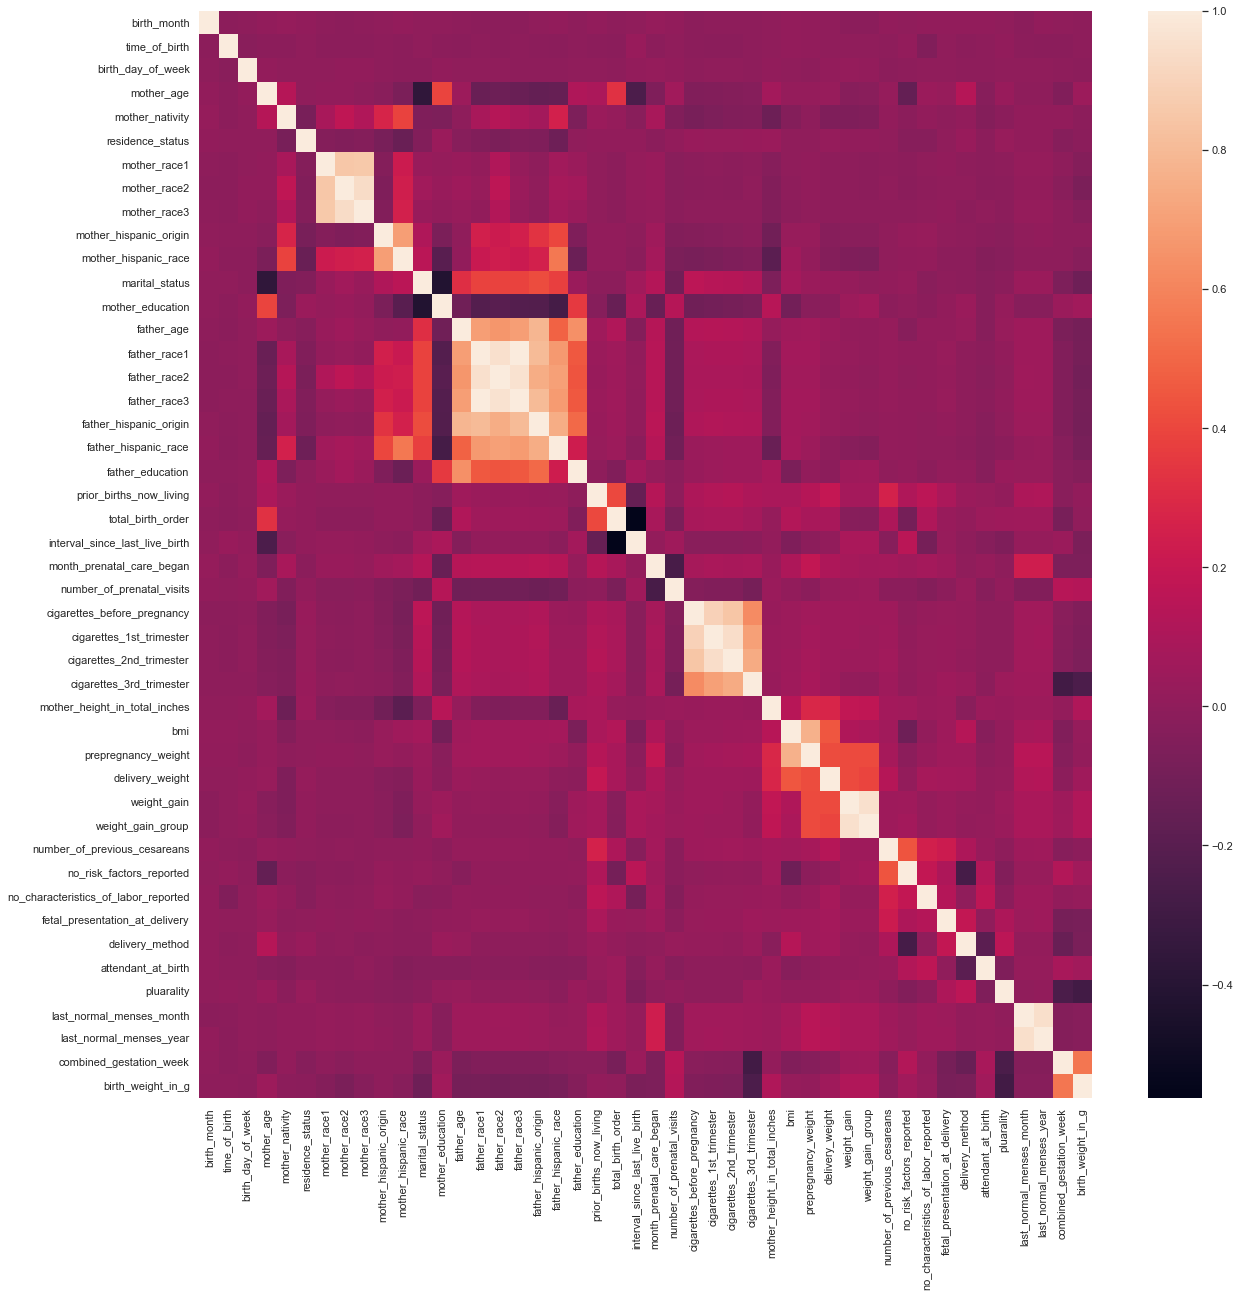

In [10]:
# check correlation
corr = X_train.corr()

sns.set(rc={'figure.figsize':(20,20)})

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)


In [11]:
# remove highly correlated features

def remove_correlated_features(X_features):
    columns_to_be_dropped = []

    # keep mother_race1 because it has the most groups 31 values
    columns_to_be_dropped.append('mother_race2')
    columns_to_be_dropped.append('mother_race3')
    columns_to_be_dropped.append('mother_hispanic_origin')
    # the same for father's race. However heatmap shows high correlation between father's race2 and hispanic_origin and age
    columns_to_be_dropped.append('father_race1')
    columns_to_be_dropped.append('father_race2')
    columns_to_be_dropped.append('father_race3')
    columns_to_be_dropped.append('father_hispanic_origin')
    columns_to_be_dropped.append('father_hispanic_race') # mother's and father's race are highly correlated

    # cigarettes - keep cigarettes before pregnancy
    columns_to_be_dropped.append('cigarettes_1st_trimester') 
    columns_to_be_dropped.append('cigarettes_2nd_trimester')
    columns_to_be_dropped.append('cigarettes_3rd_trimester')

    # father's age and education are highly correlated
    columns_to_be_dropped.append('father_education')

    # keep BMI, BMI, prepregancy_weight, delivery_weight are highly correlated
    columns_to_be_dropped.append('prepregnancy_weight')
    columns_to_be_dropped.append('delivery_weight')

    # weight gain - keep weight_gain_group
    columns_to_be_dropped.append('weight_gain')

    # heatmap shows correlation between last_normal_menses_month and year.
    columns_to_be_dropped.append('last_normal_menses_year')

    X_features = X_features.drop(columns_to_be_dropped, axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_train = remove_correlated_features(X_train)


(23879, 47)


In [12]:
# remove features that we don't know ahead of time

def features_not_known_ahead(X_features):
    columns_to_be_dropped = []

    columns_to_be_dropped.append('time_of_birth')
    columns_to_be_dropped.append('birth_day_of_week')
    columns_to_be_dropped.append('induction_of_labor')
    columns_to_be_dropped.append('augmentation_of_labor')
    columns_to_be_dropped.append('steriods')
    columns_to_be_dropped.append('antibiotics')
    columns_to_be_dropped.append('anesthesia')
    columns_to_be_dropped.append('no_characteristics_of_labor_reported')
    columns_to_be_dropped.append('fetal_presentation_at_delivery')
    columns_to_be_dropped.append('delivery_method')

    X_features = X_features.drop(columns_to_be_dropped, axis=1, errors='ignore')
    print(X_features.shape)
    return X_features

X_train = features_not_known_ahead(X_train)


(23879, 37)


In [13]:
# check data type - numerical or categorical
for feature in X_train.columns:
    print(f"{feature} = {X_train[feature].dtype}")
          

birth_month = int64
mother_age = int64
mother_nativity = int64
residence_status = int64
mother_race1 = int64
mother_hispanic_race = int64
paternity_acknowledged = object
marital_status = float64
mother_education = int64
father_age = int64
prior_births_now_living = int64
total_birth_order = int64
interval_since_last_live_birth = int64
month_prenatal_care_began = int64
number_of_prenatal_visits = int64
wic = object
cigarettes_before_pregnancy = int64
mother_height_in_total_inches = int64
bmi = int64
weight_gain_group = int64
gestational_diabetes = object
prepregnancy_hypertension = object
gestational_hypertension = object
previous_preterm_birth = object
infertility_treatment_used = object
fertility_enhancing_drugs = object
previous_cesarean = object
number_of_previous_cesareans = int64
no_risk_factors_reported = int64
chlamydia = object
attendant_at_birth = int64
pluarality = int64
sex_of_infant = object
last_normal_menses_month = int64
combined_gestation_week = int64
birth_weight_in_g =

In [14]:
# plot feature vs birthweight

# it takes two minutes to generate the charts
def feature_vs_output(X_features, output_feature):
  '''Function to plot boxplots for all features vs. output'''

  categorical_features = [feature for feature in X_features.columns]
  train_categorical = X_train[categorical_features]
  train_categorical.fillna("NA", inplace=True)

  fig, axs = plt.subplots(nrows=len(categorical_features)) # Create figure and subplots
  fig.set_size_inches(10, 6*len(categorical_features)) # Set figure size
  for i,feature_name in enumerate(categorical_features): # Iterate through features for plotting
    sns.boxplot(x=feature_name, y=output_feature, data=train_categorical, ax=axs[i]) # Generate boxplot
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90) # Rotate tick labels for easier viewing
    axs[i].title.set_text(f"{feature_name} vs {output_feature}") # Set title for each subplot


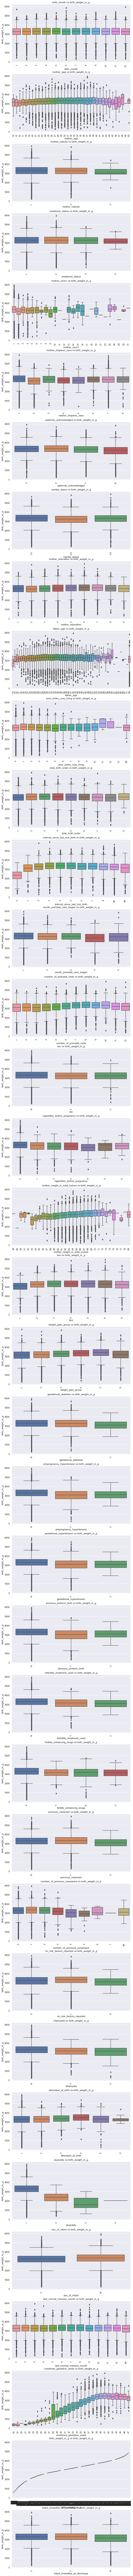

In [41]:
feature_vs_output(X_train, "birth_weight_in_g")

In [ ]:
feature_vs_output(X_train, "combined_gestation_week")

<AxesSubplot:>

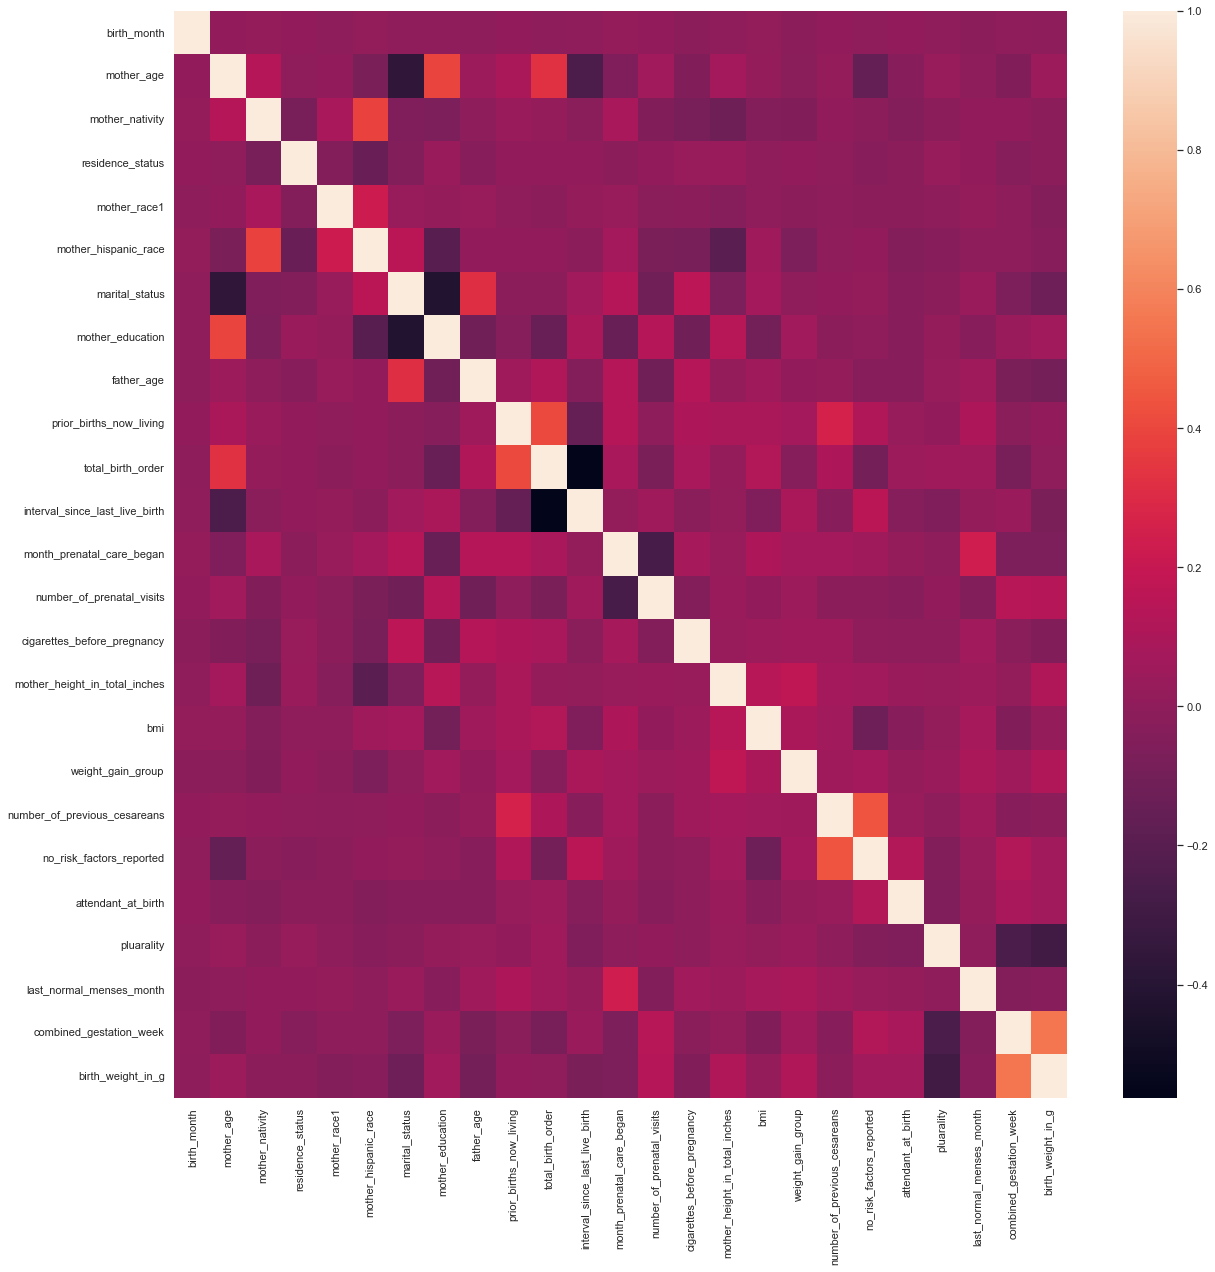

In [17]:
# check correlation
corr = X_train.corr()

sns.set(rc={'figure.figsize':(20,20)})

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)


In [18]:
# handle NA
#X_train.isna().any()
def handle_na(X_features):
    X_features['marital_status'] = X_features.marital_status.fillna(3)
    X_features['paternity_acknowledged'] = X_features.paternity_acknowledged.fillna('U')
    print(X_features.isna().any())
    return X_features

X_train = handle_na(X_train)

birth_month                       False
mother_age                        False
mother_nativity                   False
residence_status                  False
mother_race1                      False
mother_hispanic_race              False
paternity_acknowledged            False
marital_status                    False
mother_education                  False
father_age                        False
prior_births_now_living           False
total_birth_order                 False
interval_since_last_live_birth    False
month_prenatal_care_began         False
number_of_prenatal_visits         False
wic                               False
cigarettes_before_pregnancy       False
mother_height_in_total_inches     False
bmi                               False
weight_gain_group                 False
gestational_diabetes              False
prepregnancy_hypertension         False
gestational_hypertension          False
previous_preterm_birth            False
infertility_treatment_used        False


In [40]:
# convert categorical features to numeric and scale them

def scale_features(X_features):
    # it turns out all of them can be treated as categorical variables. 
    X_features_rank = pd.DataFrame()

    # The following code ranks the value by its relation to birth_weight_in_g
    # Example: mother_nativity has 3 values, 1=born in the US, 2=outside, 3=unknown
    # instead of using these values for model, we want to rank them 0, 1, 2 by the mean(birth_weight_in_g)
    # let's say 
    #   mean(birth_weight_in_g) with value 1 (born in the US) is 3500 grams
    #   mean(birth_weight_in_g) with value 2 (outside) is 2500 grams
    #   mean(birth_weight_in_g) with value 3 (unknown) is 1500 grams
    #   then order them. In this case, we will assign 0 to 3 (unknown), 1 to 2 (outside), 2 to 1 (US)
    for feature in X_features.columns:
        labels_ordered = X_features.groupby([feature])['birth_weight_in_g'].mean().sort_values().index
        labels_ordered = {k:i for i,k in enumerate(labels_ordered, 0)}
        # print(f"{feature}: {labels_ordered}")
        X_features_rank[feature] = X_features[feature].map(labels_ordered)


    # get all features except birth_weight_in_g
    feature_scale=[feature for feature in X_features_rank.columns if feature not in ['birth_weight_in_g', 'combined_gestation_week']]

    # all values will be standardized to standard normal distribution with zero mean
    scaler = StandardScaler() # Initialize StandardScaler object
    
    X_features_scaled = scaler.fit_transform(X_features_rank[feature_scale]) # Fit scaler on and transform the data
    
    # output the mean and standard deviation. It will be used for test's input 
    train_mean = pd.DataFrame(data=scaler.mean_.reshape(1, len(scaler.mean_)), columns=scaler.feature_names_in_)
    display(train_mean)
    train_mean.to_csv("data_files/train_mean.csv", index=False)
    train_stddev = pd.DataFrame(data=scaler.mean_.reshape(1, len(scaler.mean_)), columns=scaler.feature_names_in_)
    display(train_stddev)
    train_mean.to_csv("data_files/train_stddev.csv", index=False)
    
    X_features_transformed = pd.DataFrame(X_features_scaled, columns=feature_scale) # Convert back into dataframe

    return X_features_transformed

X_train_transformed = scale_features(X_train)
X_train_transformed

,birth_month,mother_age,mother_nativity,residence_status,mother_race1,mother_hispanic_race,paternity_acknowledged,marital_status,mother_education,father_age,...,fertility_enhancing_drugs,previous_cesarean,number_of_previous_cesareans,no_risk_factors_reported,chlamydia,attendant_at_birth,pluarality,sex_of_infant,last_normal_menses_month,infant_breastfed_at_discharge
0,5.543825,24.563968,1.784162,2.623016,15.721345,5.036643,2.0843,1.178232,4.45584,32.040956,...,2.938649,1.15076,6.214456,1.657565,1.97324,0.506386,2.96633,0.511454,6.228778,1.582771


,birth_month,mother_age,mother_nativity,residence_status,mother_race1,mother_hispanic_race,paternity_acknowledged,marital_status,mother_education,father_age,...,fertility_enhancing_drugs,previous_cesarean,number_of_previous_cesareans,no_risk_factors_reported,chlamydia,attendant_at_birth,pluarality,sex_of_infant,last_normal_menses_month,infant_breastfed_at_discharge
0,5.543825,24.563968,1.784162,2.623016,15.721345,5.036643,2.0843,1.178232,4.45584,32.040956,...,2.938649,1.15076,6.214456,1.657565,1.97324,0.506386,2.96633,0.511454,6.228778,1.582771


,birth_month,mother_age,mother_nativity,residence_status,mother_race1,mother_hispanic_race,paternity_acknowledged,marital_status,mother_education,father_age,...,fertility_enhancing_drugs,previous_cesarean,number_of_previous_cesareans,no_risk_factors_reported,chlamydia,attendant_at_birth,pluarality,sex_of_infant,last_normal_menses_month,infant_breastfed_at_discharge
0,-1.305269,0.204314,0.518267,0.604450,0.539875,0.763051,-0.078229,-0.193005,-0.927067,1.049565,...,0.15434,-0.416726,-0.301458,0.717118,0.142347,2.287149,0.175298,-1.023176,-1.447407,-0.793375
1,-0.156220,-0.791625,0.518267,0.604450,-1.118614,-0.791534,-0.078229,-0.193005,-1.304562,-2.033180,...,0.15434,-0.416726,-0.301458,0.717118,0.142347,0.452744,-5.031101,0.977349,-0.616960,-0.793375
2,-0.730745,-0.364794,0.518267,-0.998935,0.539875,0.763051,0.849751,0.889881,1.337902,0.899187,...,0.15434,-0.416726,-0.301458,0.717118,0.142347,-0.464459,0.175298,0.977349,-1.170591,0.568008
3,-1.018007,0.346591,0.518267,-0.998935,0.539875,0.763051,0.849751,0.889881,0.960407,0.823998,...,0.15434,-0.416726,-0.301458,0.717118,0.142347,-0.464459,0.175298,-1.023176,-0.893776,0.568008
4,1.280090,-0.080240,0.518267,0.604450,-2.066322,-1.957473,0.849751,0.889881,-0.172077,0.072109,...,0.15434,2.347443,2.509917,-1.377056,0.142347,0.452744,0.175298,-1.023176,1.043933,0.568008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23874,-1.592531,-0.364794,-1.882917,0.604450,0.539875,-0.014241,0.849751,0.889881,-0.172077,-0.228646,...,0.15434,-0.416726,-0.301458,-1.377056,0.142347,0.452744,0.175298,-1.023176,1.320748,-2.154757
23875,1.280090,0.204314,0.518267,0.604450,0.539875,0.763051,0.849751,0.889881,-0.172077,-0.003079,...,0.15434,-0.416726,-0.301458,0.717118,0.142347,-0.464459,0.175298,-1.023176,1.043933,0.568008
23876,-0.156220,-0.364794,0.518267,0.604450,0.539875,0.763051,0.849751,0.889881,-0.172077,-0.303835,...,0.15434,2.347443,2.509917,-1.377056,0.142347,-0.464459,0.175298,0.977349,-1.724222,-2.154757
23877,-1.592531,1.057976,0.518267,0.604450,0.539875,0.763051,0.849751,0.889881,-0.172077,-0.980535,...,0.15434,-0.416726,-0.301458,0.717118,0.142347,-0.464459,0.175298,-1.023176,1.320748,0.568008


## Split Data to Train and Validation

In [24]:
# split train to train + validation
X_train_after_processing, X_val_after_processing, y_train_after_processing, y_val_after_processing = \
    train_test_split(X_train_transformed, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

print(f"Train feature shape: {X_train_after_processing.shape}, output shape: {y_train_after_processing.shape}")
print(f"Validation feature shape: {X_val_after_processing.shape}, output shape: {y_val_after_processing.shape}")

Train feature shape: (17909, 35), output shape: (17909, 2)
Validation feature shape: (5970, 35), output shape: (5970, 2)


In [23]:
# save data to CSV
X_train_after_processing.to_csv("data_files/data_x_train.csv", index=False)
y_train_after_processing.to_csv("data_files/data_y_train.csv", index=False)
X_val_after_processing.to_csv("data_files/data_x_val.csv", index=False)
y_val_after_processing.to_csv("data_files/data_y_val.csv", index=False)
X_test.to_csv("data_files/data_x_test.csv", index=False)
y_test.to_csv("data_files/data_y_test.csv", index=False)